# Loan default notebook

Many credit decisioning systems are driven by scorecards, which are very simplistic rules-based systems. These are built by end-user organizations through industry knowledge or through simple statistical systems. Some organizations go a step further and obtain scorecards from third parties which may not be customized for an individual organization’s book. An AI-based approach can help financial institutions learn signals from their own book and assess risk at a more granular level. Once the risk is calculated, a strategy may be implemented to use this information for interventions. If you can predict someone is going to default, this may lead to intervention steps such as sending earlier notices or rejecting loan applications.

## Setup

This example assumes that the DataRobot Python client package has been installed and configured with the credentials of a DataRobot user with API access permissions. Retrieve your DataRobot API Token by logging into DataRobot and navigating to the Developer Tools in your profile.


In [ ]:
!pip install datarobot umap-learn nbformat hdbscan

import datarobot as dr
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

light_blue = "#598fd6"
grey_blue = "#5f728b"
orange = "#dd6b3d"

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [ ]:
# If the config file is not in the default location described in the API Quickstart guide, '~/.config/datarobot/drconfig.yaml', then you will need to call
# dr.Client(config_path='path-to-drconfig.yaml')

### Import data

The data file is hosted by DataRobot using the URL in the following cell. Read in the data directly from the URL into a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) and display the results to verify all of the data looks correct. If you have your own data files you can access that data in several ways.

In [4]:
data_path = "https://s3.amazonaws.com/datarobot-use-case-datasets/Lending+Club+Dataset+Train.csv"

pathfinder_df = pd.read_csv(data_path, encoding="ISO-8859-1")
pathfinder_df.rename(columns={"loan_is_bad": "is_bad"}, inplace=True)

pathfinder_df.head(100)

id  member_id  loan_amnt  funded_amnt  installment grade sub_grade  \
0   3296446    4068857      11200        11200       343.89     A        A2   
1   3286412    4058853      10000        10000       328.06     B        B2   
2   3286406    4058848       8000         8000       282.41     C        C4   
3   3296434    4068843      16000        16000       500.65     A        A4   
4   3286395    4058836       4000         4000       125.17     A        A4   
..      ...        ...        ...          ...          ...   ...       ...   
95  3286021    4058369       4000         4000       146.12     D        D3   
96  2835185    3417435       8500         8500       264.88     A        A3   
97  3241124    3984059      13000        13000       432.54     B        B3   
98  3198040    3930968      20000        20000       608.72     A        A1   
99  3188257    3921251      16000        16000       387.40     C        C3   

                    emp_title  emp_length home_ownership  ...  revol_util  \
0       Nokia Siemens Network        10.0            OWN  ...      66.20%   
1    creative financial group         2.0       MORTGAGE  ...      74.20%   
2            Techtron Systems         7.0           RENT  ...         72%   
3            Bristol Hospital        10.0       MORTGAGE  ...      75.20%   
4        Aspen Skiing Company        10.0       MORTGAGE  ...      95.50%   
..                        ...         ...            ...  ...         ...   
95      Morton Plant Hospital         6.0       MORTGAGE  ...      84.80%   
96    The Adocate/Hearst News         5.0       MORTGAGE  ...      28.70%   
97              Southwest ISD         3.0       MORTGAGE  ...      57.90%   
98  west texas a&m university         5.0       MORTGAGE  ...      39.90%   
99                Antea Group         1.0       MORTGAGE  ...      54.60%   

   total_acc initial_list_status collections_12_mths_ex_med  \
0         21                   f                          0   
1         11                   f                          0   
2         17                   w                          0   
3         56                   f                          0   
4         21                   w                          0   
..       ...                 ...                        ...   
95        21                   f                          0   
96        19                   w                          0   
97        18                   f                          0   
98        27                   f                          0   
99        28                   f                          0   

   mths_since_last_major_derog  application_type  acc_now_delinq tot_coll_amt  \
0                          NaN        INDIVIDUAL               0          0.0   
1                          NaN        INDIVIDUAL               0          0.0   
2                          NaN        INDIVIDUAL               0          0.0   
3                          NaN        INDIVIDUAL               0          0.0   
4                          NaN        INDIVIDUAL               0          0.0   
..                         ...               ...             ...          ...   
95                         NaN        INDIVIDUAL               0          0.0   
96                         NaN        INDIVIDUAL               0          0.0   
97                         NaN        INDIVIDUAL               0        202.0   
98                         NaN        INDIVIDUAL               0          0.0   
99                         NaN        INDIVIDUAL               0          0.0   

    tot_cur_bal  is_bad  
0      187717.0   False  
1       16623.0    True  
2       17938.0   False  
3      372771.0   False  
4      331205.0   False  
..          ...     ...  
95     112600.0   False  
96     112238.0   False  
97     120076.0   False  
98     230748.0   False  
99     194506.0   False  

[100 rows x 34 columns]

### Visualize data

Use the following snippets to display unique aspects of the data. The first cell groups the dataframe by average annual income for loans that default and those that do not. The second cell shows how often a loan defaults based on the `emp_length value`. The third cells shows the average default rate for loans for each state.

In [5]:
df1 = pathfinder_df.groupby("is_bad").agg({"annual_inc": "mean"}).reset_index()

df1

is_bad    annual_inc
0   False  72630.592408
1    True  64442.019078

In [6]:
avg_value_df = pathfinder_df.groupby("emp_length").agg({"is_bad": "mean"}).reset_index()

avg_value_df

emp_length    is_bad
0         1.0  0.150927
1         2.0  0.154332
2         3.0  0.164575
3         4.0  0.156938
4         5.0  0.149490
5         6.0  0.162082
6         7.0  0.168053
7         8.0  0.160577
8         9.0  0.169727
9        10.0  0.149395

In [26]:
avg_value_df = pathfinder_df.groupby("addr_state").agg({"is_bad": "mean"}).reset_index()

avg_value_df

addr_state    is_bad
0          AK  0.098837
1          AL  0.188563
2          AR  0.165803
3          AZ  0.168299
4          CA  0.151439
5          CO  0.138211
6          CT  0.155527
7          DC  0.091549
8          DE  0.157895
9          FL  0.180175
10         GA  0.153999
11         HI  0.192926
12         IL  0.129351
13         IN  0.166667
14         KS  0.127615
15         KY  0.140515
16         LA  0.161716
17         MA  0.150280
18         MD  0.165319
19         MI  0.173405
20         MN  0.138249
21         MO  0.153558
22         MT  0.131579
23         NC  0.147039
24         NE  1.000000
25         NH  0.101695
26         NJ  0.181864
27         NM  0.160000
28         NV  0.175192
29         NY  0.173567
30         OH  0.150431
31         OK  0.163121
32         OR  0.136858
33         PA  0.159287
34         RI  0.200855
35         SC  0.145000
36         SD  0.104839
37         TN  0.000000
38         TX  0.133150
39         UT  0.161290
40         VA  0.164849
41         VT  0.208696
42         WA  0.159657
43         WI  0.149385
44         WV  0.110092
45         WY  0.103448

## Initiate modeling
 
Create a DataRobot project to train models against the assembled dataset.

In [ ]:
EXISTING_PROJECT_ID = None  # If you've already created a project, replace None with the ID here
if EXISTING_PROJECT_ID is None:
    # Create project and pass in data
    project = dr.Project.create(sourcedata=pathfinder_df, project_name="Predict loan defaults")

    # Set the project target to the appropriate feature. Use the LogLoss metric to measure performance
    project.set_target(target="is_bad", mode=dr.AUTOPILOT_MODE.QUICK, worker_count="-1")
else:
    # Fetch the existing project
    project = dr.Project.get(EXISTING_PROJECT_ID)

project.wait_for_autopilot(check_interval=30)
# Uncomment and replace the project ID if the project already exists
# project = dr.Project.get("612cb904ce5d5617d67af394")

# Get the project metric (i.e LogLoss, RMSE, etc...)
metric = project.metric

# Get project URL
project_url = project.get_leaderboard_ui_permalink()

# Get project ID
project_id = project.id

#### View project in UI

If you want to view any aspects of the project in the DataRobot UI, you can retrieve the URL for the project with the snippet below and use it to navigate to the DataRobot application in your browser.

In [16]:
# Display project URL
project_url

'https://app.datarobot.com/projects/62cda041ab0bc3275f7a4a86/models'

### Initiate modeling

In [17]:
project.wait_for_autopilot(check_interval=30)

In progress: 0, queued: 0 (waited: 0s)


## Evaluate model performance 

In order to measure model performance, first select the top model based on a specific performance metric (i.e., `LogLoss`) and then evaluate several different types of charts, such as Lift Chart, ROC Curve, and Feature Importance. There are two helper functions (detailed below) that assist in producing these charts.

You can reference more information about how to evaluate model performance in the [DataRobot platform documentation](https://docs.datarobot.com/en/docs/modeling/analyze-models/index.html).

In the snippet below, use models built during Autopilot to create a list of the top-performing models based on their accuracy.


In [18]:
def sorted_by_metric(models, test_set, metric):
    models_with_score = [model for model in models if model.metrics[metric][test_set] is not None]

    return sorted(models_with_score, key=lambda model: model.metrics[metric][test_set])

In [19]:
models = project.get_models()

# Uncomment if this is not set above in the create project cell
metric = project.metric

# Get the top-performing model
model_top = sorted_by_metric(models, "crossValidation", metric)[0]

print(
    """The top performing model is {model} using metric, {metric}""".format(
        model=str(model_top), metric=metric
    )
)

The top performing model is Model('Elastic-Net Classifier (L2 / Binomial Deviance)') using metric, LogLoss


In [22]:
# Set styling
dr_dark_blue = "#08233F"
dr_blue = "#1F77B4"
dr_orange = "#FF7F0E"
dr_red = "#BE3C28"

# Function to build histograms


def rebin_df(raw_df, number_of_bins):
    cols = ["bin", "actual_mean", "predicted_mean", "bin_weight"]
    new_df = pd.DataFrame(columns=cols)
    current_prediction_total = 0
    current_actual_total = 0
    current_row_total = 0
    x_index = 1
    bin_size = 60 / number_of_bins
    for rowId, data in raw_df.iterrows():
        current_prediction_total += data["predicted"] * data["bin_weight"]
        current_actual_total += data["actual"] * data["bin_weight"]
        current_row_total += data["bin_weight"]

        if (rowId + 1) % bin_size == 0:
            x_index += 1
            bin_properties = {
                "bin": ((round(rowId + 1) / 60) * number_of_bins),
                "actual_mean": current_actual_total / current_row_total,
                "predicted_mean": current_prediction_total / current_row_total,
                "bin_weight": current_row_total,
            }

            new_df = new_df.append(bin_properties, ignore_index=True)
            current_prediction_total = 0
            current_actual_total = 0
            current_row_total = 0
    return new_df

### Lift chart

A [lift chart](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/lift-chart.html#lift-chart) shows you how close model predictions are to the actual values of the target in the training data. The lift chart data includes the average predicted value and the average actual values of the target, sorted by the prediction values in ascending order and split into up to 60 bins.


In [ ]:
# Function to build lift charts


def matplotlib_lift(bins_df, bin_count, ax):
    grouped = rebin_df(bins_df, bin_count)
    ax.plot(
        range(1, len(grouped) + 1),
        grouped["predicted_mean"],
        marker="+",
        lw=1,
        color=dr_blue,
        label="predicted",
    )
    ax.plot(
        range(1, len(grouped) + 1),
        grouped["actual_mean"],
        marker="*",
        lw=1,
        color=dr_orange,
        label="actual",
    )
    ax.set_xlim([0, len(grouped) + 1])
    ax.set_facecolor(dr_dark_blue)
    ax.legend(loc="best")
    ax.set_title("Lift chart {} bins".format(bin_count))
    ax.set_xlabel("Sorted Prediction")
    ax.set_ylabel("Value")
    return grouped

No handles with labels found to put in legend.
No handles with labels found to put in legend.


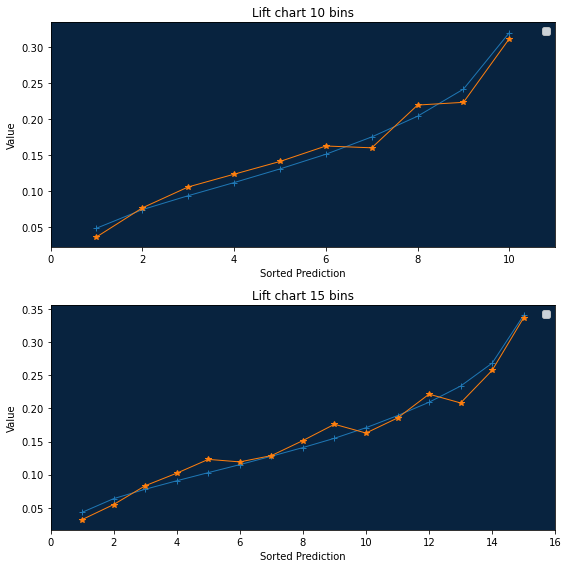

In [23]:
lift_chart = model_top.get_lift_chart("validation")

# Save the result into a Pandas dataframe
lift_df = pd.DataFrame(lift_chart.bins)

bin_counts = [10, 15]
f, axarr = plt.subplots(len(bin_counts))
f.set_size_inches((8, 4 * len(bin_counts)))

rebinned_dfs = []
for i in range(len(bin_counts)):
    rebinned_dfs.append(matplotlib_lift(lift_df, bin_counts[i], axarr[i]))

plt.tight_layout()

### ROC Curve

The receiver operating characteristic curve, or [ROC curve](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/roc-curve-tab/roc-curve.html#roc-curve), is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.


In [24]:
roc = model_top.get_roc_curve("validation")

# Save the result into a pandas dataframe
roc_df = pd.DataFrame(roc.roc_points)

roc_df

accuracy  f1_score  false_negative_score  true_negative_score  \
0    0.843687  0.000000                  1238                 6682   
1    0.844066  0.004835                  1235                 6682   
2    0.843939  0.006431                  1234                 6680   
3    0.844318  0.014388                  1229                 6678   
4    0.844444  0.025316                  1222                 6672   
..        ...       ...                   ...                  ...   
110  0.184848  0.276071                     7                  233   
111  0.175253  0.274061                     5                  155   
112  0.165657  0.272086                     3                   77   
113  0.156439  0.270394                     0                    1   
114  0.156313  0.270365                     0                    0   

     true_positive_score  false_positive_score  true_negative_rate  \
0                      0                     0            1.000000   
1                      3                     0            1.000000   
2                      4                     2            0.999701   
3                      9                     4            0.999401   
4                     16                    10            0.998503   
..                   ...                   ...                 ...   
110                 1231                  6449            0.034870   
111                 1233                  6527            0.023197   
112                 1235                  6605            0.011523   
113                 1238                  6681            0.000150   
114                 1238                  6682            0.000000   

     false_positive_rate  true_positive_rate  \
0               0.000000            0.000000   
1               0.000000            0.002423   
2               0.000299            0.003231   
3               0.000599            0.007270   
4               0.001497            0.012924   
..                   ...                 ...   
110             0.965130            0.994346   
111             0.976803            0.995961   
112             0.988477            0.997577   
113             0.999850            1.000000   
114             1.000000            1.000000   

     matthews_correlation_coefficient  positive_predictive_value  \
0                            0.000000                   0.000000   
1                            0.045224                   1.000000   
2                            0.038695                   0.666667   
3                            0.059846                   0.692308   
4                            0.072549                   0.615385   
..                                ...                        ...   
110                          0.061893                   0.160286   
111                          0.049450                   0.158892   
112                          0.033049                   0.157526   
113                          0.004837                   0.156333   
114                          0.000000                   0.156313   

     negative_predictive_value  threshold  fraction_predicted_as_positive  \
0                     0.843687   1.000000                        0.000000   
1                     0.844007   0.514413                        0.000379   
2                     0.844074   0.477247                        0.000758   
3                     0.844568   0.449702                        0.001641   
4                     0.845199   0.423901                        0.003283   
..                         ...        ...                             ...   
110                   0.970833   0.043229                        0.969697   
111                   0.968750   0.039698                        0.979798   
112                   0.962500   0.033700                        0.989899   
113                   1.000000   0.019673                        0.999874   
114                   0.000000   0.000044                        1.000000   

    

In [ ]:
dr_roc_green = "#03c75f"
white = "#ffffff"
dr_purple = "#65147D"
dr_dense_green = "#018f4f"

threshold = roc.get_best_f1_threshold()
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(1, 1, 1, facecolor=dr_dark_blue)

plt.scatter(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot([0, 1], [0, 1], color=white, alpha=0.25)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.xlim([0, 1])
plt.ylabel("True Positive Rate")
plt.ylim([0, 1])

### Feature Impact

[Feature Impact](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-impact.html) measures how important a feature is in the context of a model. It measures how much the accuracy of a model would decrease if that feature was removed.

Feature Impact is available for all model types and works by altering input data and observing the effect on a model’s score. It is an on-demand feature, meaning that you must initiate a calculation to see the results. Once DataRobot computes the feature impact for a model, that information is saved with the project.


Text(0.5, 1.04, 'Feature Impact')

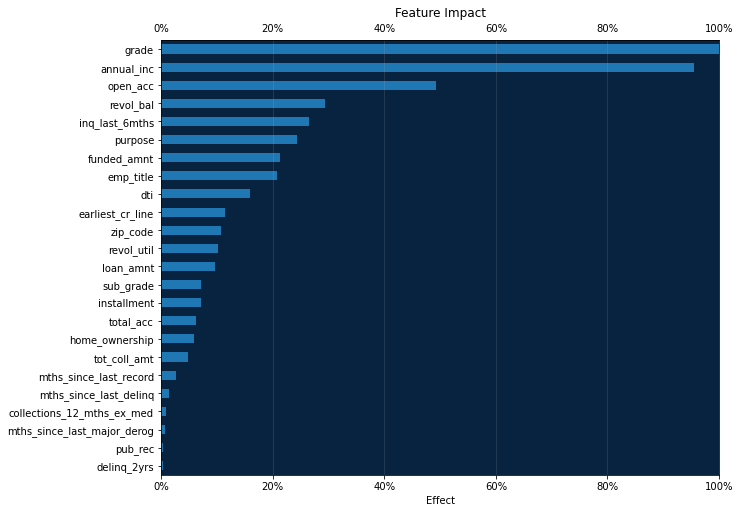

In [25]:
feature_impacts = model_top.get_or_request_feature_impact()

# Limit size to make chart look good. Display top 25 values
if len(feature_impacts) > 25:
    feature_impacts = feature_impacts[0:24]

# Formats the ticks from a float into a percent
percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

impact_df = pd.DataFrame(feature_impacts)
impact_df.sort_values(by="impactNormalized", ascending=True, inplace=True)

# Positive values are blue, negative are red
bar_colors = impact_df.impactNormalized.apply(lambda x: dr_red if x < 0 else dr_blue)

ax = impact_df.plot.barh(
    x="featureName", y="impactNormalized", legend=False, color=bar_colors, figsize=(10, 8)
)
ax.xaxis.set_major_formatter(percent_tick_fmt)
ax.xaxis.set_tick_params(labeltop=True)
ax.xaxis.grid(True, alpha=0.2)
ax.set_facecolor(dr_dark_blue)

plt.ylabel("")
plt.xlabel("Effect")
plt.xlim((None, 1))  # Allow for negative impact
plt.title("Feature Impact", y=1.04);

## Make predictions

### Test predictions

After determining the top-performing model from the Leaderboard, upload the prediction test dataset to verify that the model generates predictions successfully before deploying the model to a production environment. The predictions are returned as a Pandas dataframe. 

In [ ]:
data_path_scoring = (
    "https://s3.amazonaws.com/datarobot-use-case-datasets/Lending+Club+Dataset+Pred.csv"
)
scoring_df = pd.read_csv(data_path_scoring, encoding="ISO-8859-1")
pathfinder_df.rename(columns={"loan_is_bad": "is_bad"}, inplace=True)

prediction_dataset = project.upload_dataset(scoring_df)
predict_job = model_top.request_predictions(prediction_dataset.id)
prediction_dataset.id

predictions = predict_job.get_result_when_complete()
pd.concat([scoring_df, predictions], axis=1)
predictions.positive_probability.plot(kind="hist", title="Predicted Probabilities")

### Deploy a model to production


If you are happy with the model's performance, you can deploy it to a production environment with [MLOps](https://docs.datarobot.com/en/mlops/index.html).  Deploying the model will free up workers, as data scored through the deployment doesn't use any modeling workers. Furthermore, you are no longer restricted on the amount of data to score; score over 100GB with the deployment. Deployments also offer many model management benefits: monitoring service, data drift, model comparison, retraining, and more.

In [33]:
# Retrieve a prediction server
prediction_server = dr.PredictionServer.list()[0]

# Get the top performing model. Uncomment if this did not execute in the previous section
# model_top = sorted_by_metric(models, 'crossValidation', metric)[0]
deployment = dr.Deployment.create_from_learning_model(
    model_top.id,
    label="Predicting Loan Defaults",
    description="Predicting Loan Defaults",
    default_prediction_server_id=prediction_server.id,
)
deployment.id

Deployment(Late Shipment Predictions)

### Configure batch predictions

After the model has been deployed, DataRobot creates an endpoint for real-time scoring. The deployment allows you to use DataRobot's batch prediction API to score large datasets with a deployed DataRobot model. 

The batch prediction API provides flexible intake and output options when scoring large datasets using prediction servers. The API is exposed through the DataRobot Public API and can be consumed using a REST-enabled client or Public API bindings for DataRobot's Python client.

#### Set the deployment ID

Before proceeding, provide the deployed model's deployment ID (retrieved from the deployment's [Overview tab](https://docs.datarobot.com/en/docs/mlops/monitor/dep-overview.html) or from the Deployment object in the Python client: `deployment.id`).

In [ ]:
deployment_id = "YOUR_DEPLOYMENT_ID"

#### Determine input and output options

DataRobot's batch prediction API allows you to score data from and to multiple sources. You can take advantage of the credentials and data sources you have already established previously through the UI for easy scoring. Credentials are usernames and passwords, while data sources are any databases with which you have previously established a connection (e.g., Snowflake). View the example code below outlining how to query credentials and data sources.

You can reference the full list of DataRobot's supported [input](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/intake-options.html) and [output options](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/output-options.html).

Reference the DataRobot documentation for more information about [data connections](https://docs.datarobot.com/en/docs/data/connect-data/data-conn.html).

The snippet below shows how you can query all credentials tied to a DataRobot account.

In [ ]:
dr.Credential.list()

The output above returns multiple sets of credentials. The alphanumeric string included in each item of the list is the credentials ID. You can use that ID to access credentials through the API.

The snippet below shows how you can query all data sources tied to a DataRobot account. The second line lists each datastore with an alphanumeric string; that is the datastore ID.

In [6]:
dr.DataStore.list()
print(dr.DataStore.list()[0].id)

5e6696ff820e737a5bd78430


### Scoring examples

The snippets below demonstrate how to score data with the Batch Prediction API. Edit the `intake_settings` and `output_settings` to suit your needs. You can mix and match until you get the outcome you prefer.

#### Score from CSV to CSV

In [ ]:
# Scoring without Prediction Explanations
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            'type': 'localFile',
            'file': 'inputfile.csv' # Provide the filepath, Pandas dataframe, or file-like object here
        },
        output_settings={
            'type': 'localFile',
            'path: 'outputfile.csv'
        }
    )

#Scoring with Prediction Explanations
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            'type': 'localFile',
            'file': 'inputfile.csv' # Provide the filepath, Pandas dataframe, or file-like object here
        },
        output_settings={
            'type': 'localFile',
            'path': 'outputfile.csv'
        },
    
        max_explanations=3 #Compute Prediction Explanations for the amount of features indicated here
    
    )

#### Score from S3 to S3

In [ ]:
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "s3",
            "url": "s3://theos-test-bucket/lending_club_scoring.csv",  # Provide the URL of your datastore here
            "credential_id": "YOUR_CREDENTIAL_ID_FROM_ABOVE",  # Provide your credentials here
        },
        output_settings={
            "type": "s3",
            "url": "s3://theos-test-bucket/lending_club_scored2.csv",
            "credential_id": "YOUR_CREDENTIAL_ID_FROM_ABOVE",
        },
    )

#### Score from JDBC to JDBC

In [ ]:
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "jdbc",
            "table": "table_name",
            "schema": "public",
            "dataStoreId": data_store.id,  # Provide the ID of your datastore here
            "credentialId": cred.credential_id,  # Provide your credentials here
        },
        output_settings={
            "type": "jdbc",
            "table": "table_name",
            "schema": "public",
            "statementType": "insert",
            "dataStoreId": data_store.id,
            "credentialId": cred.credential_id,
        },
    )